In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
from math import radians, sin, cos, sqrt, asin

# Bike Repositioning Optimization Using Multi-Stop Truck Routing Model

William Fecteau, Tiphaine Levan, Laura Pantaléon, Ernest Bragg, Marc Pujol  
Groupe 2  
Avril 2025

- This notebook aims to optimize bike repositioning across stations by using a multi-stop truck routing optimization model with a time dimension. It begins with loading and preprocessing the datasets, followed by the filtering of trips during peak hours on Wednesdays in July.
- The analysis identifies the top 20 stations by usage and calculates station metrics like demand, supply, and net flow.
- The notebook proceeds to calculate distances between stations and create a target inventory based on these metrics, analyzing surplus and deficit conditions.
- The core of the notebook involves setting up and solving the multi-stop truck routing model using Gurobi, considering truck capacity, cost parameters, distance constraints, and station inventory balance. Finally, the results, including optimization details, truck routes, and cost breakdown, are displayed.

### 1. Load and Preprocess Data 

In [6]:
# Load datasets
stations = pd.read_csv('stations.csv')
trips = pd.read_csv('trips.csv')

# Convert date columns to datetime format for easier filtering
trips['start_date'] = pd.to_datetime(trips['start_date'])

# Filter trips for Wednesdays in July between 4-6 PM
july_trips = trips[trips['start_date'].dt.month == 7]
wed_trips = july_trips[july_trips['start_date'].dt.day_name() == 'Monday']
day = wed_trips['day_of_week'].unique() #for data exportation purpose only 
peak_trips = wed_trips[(wed_trips['start_hour'] >= 7) & (wed_trips['start_hour'] < 9)] 

print(trips.head(3))
print(stations.head(3))

    trip_id  bikeid  tripduration  from_station_id  \
0  16734065    1411           349              216   
1  16734064    3048           354              216   
2  16734063    2590           226              141   

              from_station_name  to_station_id              to_station_name  \
0  California Ave & Division St            259  California Ave & Francis Pl   
1  California Ave & Division St            259  California Ave & Francis Pl   
2        Clark St & Lincoln Ave            144    Larrabee St & Webster Ave   

  start_date_hour_minute start_date start_hour_minute  start_hour  \
0    2017-09-30 23:59:58 2017-09-30          23:59:58          23   
1    2017-09-30 23:59:53 2017-09-30          23:59:53          23   
2    2017-09-30 23:59:06 2017-09-30          23:59:06          23   

  end_date_hour_minute    end_date end_hour_minute  end_hour day_of_week  \
0  2017-10-01 00:05:47  2017-10-01        00:05:47         0    Saturday   
1  2017-10-01 00:05:47  2017-10-01   

### 2. Identify Top 20 Stations

In [8]:
# Count activity for both from and to stations
from_station_counts = peak_trips['from_station_id'].value_counts()
to_station_counts = peak_trips['to_station_id'].value_counts()

# Merge both to get total activity per station
station_activity = pd.DataFrame({
    'from_count': from_station_counts,
    'to_count': to_station_counts.reindex(from_station_counts.index, fill_value=0)
})
station_activity['total_activity'] = station_activity['from_count'] + station_activity['to_count']

# Get top 20 stations by total activity
top_20_stations = station_activity.sort_values('total_activity', ascending=False).head(20).index.tolist()

# Filter trips and stations for the top 20 stations
peak_trips_top20 = peak_trips[peak_trips['from_station_id'].isin(top_20_stations) | peak_trips['to_station_id'].isin(top_20_stations)]
stations_top20 = stations[stations['id'].isin(top_20_stations)]
print(f"Top 20 stations data: {stations_top20.shape}")
print(f"Filtered trips for top 20 stations: {peak_trips_top20.shape}")

Top 20 stations data: (20, 7)
Filtered trips for top 20 stations: (9716, 17)


### 3. Calculate Station Metrics

In [10]:
# Calculate demand (from station) and supply (to station) for each top 20 station
demand_by_station = peak_trips_top20['from_station_id'].value_counts().reindex(top_20_stations, fill_value=0)
supply_by_station = peak_trips_top20['to_station_id'].value_counts().reindex(top_20_stations, fill_value=0)

# Net flow is the difference between supply and demand
net_flow = supply_by_station - demand_by_station

# Create a summary of station metrics
station_summary = pd.DataFrame({
    'station_id': top_20_stations,
    'demand': demand_by_station.values,
    'supply': supply_by_station.values,
    'net_flow': net_flow.values
})

# Add capacity and geographic information to station summary
station_summary = station_summary.merge(
    stations_top20[['id', 'dpcapacity', 'latitude', 'longitude']], 
    left_on='station_id',
    right_on='id'
).drop('id', axis=1)

station_summary.head()

,station_id,demand,supply,net_flow,dpcapacity,latitude,longitude
0,192,802,358,-444,47,41.879255,-87.639904
1,91,762,326,-436,31,41.883380,-87.641170
2,77,532,432,-100,31,41.882242,-87.641066
3,287,50,698,648,27,41.880317,-87.635185
4,43,112,634,522,43,41.883893,-87.624649


### 4. Calculate Distance Matrix For Top 20 Stations

In [12]:
# Haversine function to calculate distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Earth radius in km
    return c * r

# Calculate distance matrix for top 20 stations
distance_matrix = np.zeros((len(top_20_stations), len(top_20_stations)))
station_id_to_idx = {station_id: idx for idx, station_id in enumerate(top_20_stations)}
for i, station_i in enumerate(top_20_stations):
    lat_i, lon_i = stations_top20[stations_top20['id'] == station_i][['latitude', 'longitude']].values[0]
    for j, station_j in enumerate(top_20_stations):
        if i != j:
            lat_j, lon_j = stations_top20[stations_top20['id'] == station_j][['latitude', 'longitude']].values[0]
            distance_matrix[i, j] = haversine_distance(lat_i, lon_i, lat_j, lon_j)

### 5. Create Target Inventory Based on Station Flow Patterns 

In [14]:
# Set target number of bikes at each station based on demand/supply
target_bikes = {}
current_bikes = {}
for idx, row in station_summary.iterrows():
    station_id = row['station_id']
    capacity = row['dpcapacity']
    net_flow_val = row['net_flow']
    
    # Set target inventory based on net flow
    target_bikes[station_id] = max(3, int(capacity * 0.3)) if net_flow_val > 0 else min(capacity - 3, int(capacity * 0.7))
    
    # Set current inventory at 50% capacity
    # This is arbitrary, since computing the number of bikes starting at a station over-complexify the model. 
    current_bikes[station_id] = int(capacity * 0.5)

# Calculate surplus and deficit for inventory adjustment
inventory_delta = {station_id: target_bikes[station_id] - current_bikes[station_id] for station_id in top_20_stations}
surplus_stations = [station_id for station_id in top_20_stations if inventory_delta[station_id] < 0]
deficit_stations = [station_id for station_id in top_20_stations if inventory_delta[station_id] > 0]

print("\nStation Inventory Analysis:")
print(f"Total Stations with surplus bikes: {len(surplus_stations)}")
print(f"Total Stations with deficit bikes: {len(deficit_stations)}")


Station Inventory Analysis:
Total Stations with surplus bikes: 12
Total Stations with deficit bikes: 8


### 6. Setup and Solve Multi-Stop Truck Routing Optimization Model

#### a. Parameters Setting 

In [17]:
# Setup the optimization model with Gurobi
model = gp.Model("MultiStopBikeRepositioning_Time")

# Model parameters (constants)
max_trucks = 20                 # Maximum number of trucks available per time period
truck_capacity = 40             # Maximum bike capacity per truck
max_stops_per_truck = 5         # Maximum number of stops a truck can make
truck_fixed_cost = 50.0         # Fixed cost per truck used
truck_transport_cost_per_km = 3.0  # Cost per km traveled
max_distance_per_truck = 50     # Maximum total distance per truck (km)
surplus_penalty = 50            # Penalty for not moving surplus bikes
deficit_penalty = 50            # Penalty for not meeting deficit
# Same Penalty for both consumer-frustated situation, since no situation is preferrable over another
# --> not enough bikes, or not enough docks.

# Helper function to create batches of decision variables with consistent patterns.
def add_vars(model, var_type, shape, name_pattern, lb=None, ub=None):
    vars_dict = {}
    for indices in shape:
        # Construct variable name
        var_name = name_pattern.format(*indices)
        # Prepare keyword arguments
        kwargs = {
            'vtype': var_type,
            'name': var_name
        } 
        # Add bounds only if specified
        if lb is not None:
            kwargs['lb'] = lb
        if ub is not None:
            kwargs['ub'] = ub  
        # Create and store variable
        vars_dict[indices] = model.addVar(**kwargs)
    return vars_dict
    
# STATION DATA PREPARATION
# Convert station IDs to numerical indices for easier modeling
all_stations = top_20_stations  # List of station IDs we're modeling
station_lookup = {station_id: i for i, station_id in enumerate(all_stations)}  # ID → index mapping
num_stations = len(all_stations)
station_indices = range(num_stations)  # 0, 1, 2,... num_stations-1
time_periods = peak_trips['start_hour'].unique().tolist()

Set parameter Username
Set parameter LicenseID to value 2608147
Academic license - for non-commercial use only - expires 2026-01-09


#### b. Decision Variables

In [19]:
#(1) TRUCK OPERATION VARIABLES
# Whether truck u is active in time period t (binary)
used = add_vars(model, GRB.BINARY, 
               ((u, t) for u in range(max_trucks) for t in time_periods),
               "used_{}_{}")

# Whether truck u visits station i as its s-th stop in period t (binary)
visit = add_vars(model, GRB.BINARY,
                ((u, i, s, t) for u in range(max_trucks) 
                 for i in station_indices 
                 for s in range(max_stops_per_truck) 
                 for t in time_periods),
                "visit_{}_{}_{}_{}")

# (2) ROUTING VARIABLES
# Whether truck u moves from station i→j after s-th stop in period t (binary)
# Note: Only created for i≠j to avoid self-transitions
next_stop = add_vars(model, GRB.BINARY,
                    ((u, i, j, s, t) for u in range(max_trucks)
                     for i in station_indices
                     for j in station_indices if i != j
                     for s in range(max_stops_per_truck-1)  # No next stop after last stop
                     for t in time_periods),
                    "next_{}_{}_{}_{}_{}")

# (3) INVENTORY MOVEMENT VARIABLES
# Bikes picked up by truck u at station i during s-th stop in period t (integer)
pickup = add_vars(model, GRB.INTEGER,
                 ((u, i, s, t) for u in range(max_trucks)
                  for i in station_indices
                  for s in range(max_stops_per_truck)
                  for t in time_periods),
                 "pickup_{}_{}_{}_{}", 
                 lb=0, ub=truck_capacity)  # Can't exceed truck capacity

# Bikes dropped off by truck u at station i during s-th stop in period t (integer)
dropoff = add_vars(model, GRB.INTEGER,
                  ((u, i, s, t) for u in range(max_trucks)
                   for i in station_indices
                   for s in range(max_stops_per_truck)
                   for t in time_periods),
                  "dropoff_{}_{}_{}_{}", 
                  lb=0, ub=truck_capacity)

# (4) TRUCK STATE VARIABLES
# Current load of truck u after s-th stop in period t (integer)
load = add_vars(model, GRB.INTEGER,
               ((u, s, t) for u in range(max_trucks)
                for s in range(max_stops_per_truck)
                for t in time_periods),
               "load_{}_{}_{}", 
               lb=0, ub=truck_capacity)

# Distance traveled by truck u in period t (continuous)
total_distance = add_vars(model, GRB.CONTINUOUS,
                         ((u, t) for u in range(max_trucks) for t in time_periods),
                         "distance_{}_{}", 
                         lb=0)  # Distance can't be negative

# (5) INVENTORY BALANCE VARIABLES
# Surplus bikes not moved from station i (across all time periods)
surplus_remaining = {
    i: model.addVar(vtype=GRB.INTEGER, 
                   lb=0, 
                   ub=abs(inventory_delta[all_stations[i]]), 
                   name=f"surplus_remaining_{i}")
    for i, station_id in enumerate(all_stations) 
    if station_id in surplus_stations  # Only create for surplus stations
}
# Deficit bikes not fulfilled at station i (across all time periods)
deficit_remaining = {
    i: model.addVar(vtype=GRB.INTEGER, 
                   lb=0, 
                   ub=inventory_delta[all_stations[i]], 
                   name=f"deficit_remaining_{i}")
    for i, station_id in enumerate(all_stations) 
    if station_id in deficit_stations  # Only create for deficit stations
}

# Finalize all variables in the model
model.update()


#### c. Constraints 

In [21]:
# (1) Truck Activation Constraints
# Link truck usage to station visits
for u in range(max_trucks):
    for t in time_periods:
        model.addConstr(
            gp.quicksum(visit[u, i, s, t] for i in station_indices for s in range(max_stops_per_truck)) 
            <= max_stops_per_truck * used[u, t],
            f"truck_usage_{u}_{t}"
        )
        
# (2) Load Management Constraints
# Initialize truck load at first stop
for u in range(max_trucks):
    for t in time_periods:
        model.addConstr(
            load[u, 0, t] == gp.quicksum(pickup[u, i, 0, t] - dropoff[u, i, 0, t] for i in station_indices),
            f"initial_load_{u}_{t}"
        )

# Track load evolution between stops
for u in range(max_trucks):
    for t in time_periods:
        for s in range(1, max_stops_per_truck):
            model.addConstr(
                load[u, s, t] == load[u, s-1, t] + 
                gp.quicksum(pickup[u, i, s, t] - dropoff[u, i, s, t] for i in station_indices),
                f"load_evolution_{u}_{s}_{t}"
            )
# (3) Visit-Operation Linkage
# Require station visit for pickup/dropoff operations
for u in range(max_trucks):
    for t in time_periods:
        for i in station_indices:
            for s in range(max_stops_per_truck):
                model.addConstr(pickup[u, i, s, t] <= truck_capacity * visit[u, i, s, t], 
                               f"pickup_visit_{u}_{i}_{s}_{t}")
                model.addConstr(dropoff[u, i, s, t] <= truck_capacity * visit[u, i, s, t], 
                               f"dropoff_visit_{u}_{i}_{s}_{t}")

# Single station per stop position
for u in range(max_trucks):
    for t in time_periods:
        for s in range(max_stops_per_truck):
            model.addConstr(
                gp.quicksum(visit[u, i, s, t] for i in station_indices) <= used[u, t],
                f"one_station_per_stop_{u}_{s}_{t}"
            )

#(4) Route Continuity Constraints
# Maintain route continuity between stops
for u in range(max_trucks):
    for t in time_periods:
        for s in range(max_stops_per_truck-1):
            model.addConstr(
                gp.quicksum(visit[u, i, s, t] for i in station_indices) >= 
                gp.quicksum(visit[u, j, s+1, t] for j in station_indices),
                f"flow_conservation_{u}_{s}_{t}"
            )

# Link next_stop variables to visit sequence
for u in range(max_trucks):
    for t in time_periods:
        for s in range(max_stops_per_truck-1):
            # Outgoing connections
            for i in station_indices:
                model.addConstr(
                    gp.quicksum(next_stop[u, i, j, s, t] for j in station_indices if j != i) 
                    == visit[u, i, s, t],
                    f"next_stop_out_{u}_{i}_{s}_{t}"
                )
            # Incoming connections
            for j in station_indices:
                model.addConstr(
                    gp.quicksum(next_stop[u, i, j, s, t] for i in station_indices if i != j) 
                    == visit[u, j, s+1, t],
                    f"next_stop_in_{u}_{j}_{s+1}_{t}"
                )

# (5) Distance Constraints
# Calculate total distance per truck
for u in range(max_trucks):
    for t in time_periods:
        model.addConstr(
            total_distance[u, t] == gp.quicksum(
                next_stop[u, i, j, s, t] * distance_matrix[i, j]
                for i in station_indices 
                for j in station_indices 
                for s in range(max_stops_per_truck-1) 
                if i != j
            ),
            f"total_distance_{u}_{t}"
        )

# Enforce maximum distance limit
for u in range(max_trucks):
    for t in time_periods:
        model.addConstr(total_distance[u, t] <= max_distance_per_truck, 
                       f"max_distance_{u}_{t}")

# (6) Inventory Balance Constraints
# Handle surplus station inventory
for i, station_id in enumerate(all_stations):
    if station_id in surplus_stations:
        model.addConstr(
            gp.quicksum(pickup[u, i, s, t] - dropoff[u, i, s, t]
                       for u in range(max_trucks) 
                       for t in time_periods 
                       for s in range(max_stops_per_truck))
            + surplus_remaining[i] == abs(inventory_delta[station_id]),
            f"surplus_balance_{i}"
        )

# Handle deficit station inventory
for i, station_id in enumerate(all_stations):
    if station_id in deficit_stations:
        model.addConstr(
            gp.quicksum(dropoff[u, i, s, t] - pickup[u, i, s, t]
                       for u in range(max_trucks) 
                       for t in time_periods 
                       for s in range(max_stops_per_truck))
            + deficit_remaining[i] == inventory_delta[station_id],
            f"deficit_balance_{i}"
        )

#### d.Objective Function 

In [23]:
# Cost Components
truck_cost = gp.quicksum(used[u, t] * truck_fixed_cost 
                        for u in range(max_trucks) 
                        for t in time_periods)
transport_cost = gp.quicksum(total_distance[u, t] * truck_transport_cost_per_km 
                        for u in range(max_trucks) 
                        for t in time_periods)
surplus_cost = gp.quicksum(surplus_remaining[i] * surplus_penalty 
                        for i, sid in enumerate(all_stations) 
                        if sid in surplus_stations)
deficit_cost = gp.quicksum(deficit_remaining[i] * deficit_penalty 
                        for i, sid in enumerate(all_stations) 
                        if sid in deficit_stations)

# Composite Objective
model.setObjective(
    truck_cost + transport_cost + surplus_cost + deficit_cost,
    GRB.MINIMIZE
)

### 6. Solution Processing

In [25]:
# --------------------------
# 1. Solve the Model (Base Case)
# --------------------------
# Set solution pool parameters BEFORE optimization
model.setParam('PoolSearchMode', 2)  # Find all solutions
model.setParam('PoolSolutions', 10)  # Keep top 10 solutions
model.setParam('OutputFlag', 1)      # Keep solver output visible
model.Params.TimeLimit = 550  # Time limit in seconds

# Solve the model
model.optimize()

# --------------------------
# 2. Analyze Solution Pool
# --------------------------
if model.SolCount > 0:
    print("\n" + "="*40)
    print(f" FOUND {model.SolCount} SOLUTIONS ".center(40, "="))

    # Print solution summaries
    for i in range(model.SolCount):
        model.Params.SolutionNumber = i  # Access solution i
        print(f"Solution {i}: Cost ${model.PoolObjVal:,.2f}")
    
    # Keep original solution active
    model.Params.SolutionNumber = 0  # Reset to best solution

# --------------------------
# 3. Process Best Solution 
# --------------------------
if model.status == GRB.OPTIMAL or (model.status == GRB.TIME_LIMIT and model.SolCount > 0):

 # (1) Solution Summary
    print("\n" + "="*40)
    print(" OPTIMIZATION RESULTS ".center(40, "="))
    print(f"{'Total Cost:':<20} ${model.ObjVal:,.2f}")
    
    active_trucks = [(u,t) for u in range(max_trucks) for t in time_periods if used[u,t].X > 0.5]
    total_trucks_used = len(active_trucks)
    print(f"{'Trucks Used:':<20} {total_trucks_used}")
    
    # (2) Truck Route Details
    print("\n" + "-"*40)
    print(" TRUCK ROUTES ".center(40, "-"))
    
    truck_renumbering = {}
    truck_counter = 1
    for u, t in active_trucks:
        truck_renumbering[(u, t)] = truck_counter
        truck_counter += 1
    
    routes = []
    for t in time_periods:
        for u in range(max_trucks):
            if used[u,t].X > 0.5:
                stops = []
                for s in range(max_stops_per_truck):
                    for i in station_indices:
                        if visit[u,i,s,t].X > 0.5:
                            station_id = all_stations[i]
                            pickup_amount = int(pickup[u,i,s,t].X + 0.5)
                            dropoff_amount = int(dropoff[u,i,s,t].X + 0.5)
                            load_after = int(load[u,s,t].X + 0.5)
                            stops.append({
                                'stop_num': s+1,
                                'station_id': station_id,
                                'pickup': pickup_amount,
                                'dropoff': dropoff_amount,
                                'net_change': pickup_amount - dropoff_amount,
                                'load_after': load_after
                            })
                truck_distance = total_distance[u,t].X
                routes.append({
                    'time_period': t,
                    'original_truck_id': u+1,
                    'sequential_truck_id': truck_renumbering[(u,t)],
                    'stops': stops,
                    'total_distance': truck_distance,
                    'distance_cost': truck_distance * truck_transport_cost_per_km,
                    'fixed_cost': truck_fixed_cost
                })
    
    routes.sort(key=lambda x: (x['time_period'], x['sequential_truck_id']))
    
    for route in routes:
        print(f"\nTime period {route['time_period']} - Truck {route['sequential_truck_id']}:")
        print(f"  Total distance: {route['total_distance']:.2f} km")
        print(f"  Total cost: ${route['fixed_cost'] + route['distance_cost']:.2f}")
        print("  Route details:")
        for stop in route['stops']:
            action = ""
            if stop['pickup'] > 0 and stop['dropoff'] > 0:
                action = f"Pickup {stop['pickup']} and Dropoff {stop['dropoff']} bikes"
            elif stop['pickup'] > 0:
                action = f"Pickup {stop['pickup']} bikes"
            elif stop['dropoff'] > 0:
                action = f"Dropoff {stop['dropoff']} bikes"
            print(f"    Stop {stop['stop_num']}: Station {stop['station_id']} - {action} (Load after: {stop['load_after']})")

    # (3) Station Inventory Status
    print("\n" + "-"*40)
    print(" STATION INVENTORY ".center(40, "-"))
    
    final_inventory = {station_id: current_bikes[station_id] for station_id in all_stations}
    for i, station_id in enumerate(all_stations):
        for t in time_periods:
            for u in range(max_trucks):
                for s in range(max_stops_per_truck):
                    if visit[u,i,s,t].X > 0.5:
                        final_inventory[station_id] -= int(pickup[u,i,s,t].X + 0.5)
                        final_inventory[station_id] += int(dropoff[u,i,s,t].X + 0.5)
    
    final_states = []
    for i, station_id in enumerate(all_stations):
        surplus_rem = surplus_remaining[i].X if station_id in surplus_stations else 0
        deficit_rem = deficit_remaining[i].X if station_id in deficit_stations else 0
        row = station_summary[station_summary['station_id'] == station_id].iloc[0]
        final_states.append({
            'station_id': station_id,
            'capacity': row['dpcapacity'],
            'current_bikes': current_bikes[station_id],
            'target_bikes': target_bikes[station_id],
            'final_bikes': final_inventory[station_id],
            'demand': row['demand'],
            'supply': row['supply'],
            'net_flow': row['net_flow'],
            'surplus_remaining': int(surplus_rem + 0.5) if surplus_rem > 0.5 else 0,
            'deficit_remaining': int(deficit_rem + 0.5) if deficit_rem > 0.5 else 0,
            'final_occupancy_rate': final_inventory[station_id] / row['dpcapacity']
        })
    
    states_df = pd.DataFrame(final_states).sort_values('station_id')
    print(states_df)
    
    # (4) Cost Breakdown
    print("\n" + "-"*40)
    print(" COST ANALYSIS ".center(40, "-"))
    
    truck_cost_value = sum(used[u,t].X * truck_fixed_cost for u in range(max_trucks) for t in time_periods)
    transport_cost_value = sum(total_distance[u,t].X * truck_transport_cost_per_km for u in range(max_trucks) for t in time_periods)
    surplus_cost_value = sum(surplus_remaining[i].X * surplus_penalty for i, sid in enumerate(all_stations) if sid in surplus_stations)
    deficit_cost_value = sum(deficit_remaining[i].X * deficit_penalty for i, sid in enumerate(all_stations) if sid in deficit_stations)
    
    print(f"{'Transportation cost:':<20} ${transport_cost_value:,.2f}")
    print(f"{'Truck fixed cost:':<20} ${truck_cost_value:,.2f}")
    print(f"{'Surplus penalty:':<20} ${surplus_cost_value:,.2f}")
    print(f"{'Deficit penalty:':<20} ${deficit_cost_value:,.2f}")
    print(f"{'Total cost:':<20} ${model.ObjVal:,.2f}")

Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 10
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 550
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  550
PoolSearchMode  2

Optimize a model with 15100 rows, 73100 columns and 235900 nonzeros
Model fingerprint: 0x65240d46
Variable types: 40 continuous, 73060 integer (64840 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [3e+00, 5e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [3e+00, 5e+01]
Found heuristic solution: objective 6300.0000000
Presolve removed 40 rows and 0 columns
Presolve time: 1.38s
Presolved: 15060 rows, 73100 columns, 233460 nonzeros
Variable types: 40 continuous, 73060 integer (6484

### 7. Result Visualization & Data Export 

#### a. Graphs And Plots

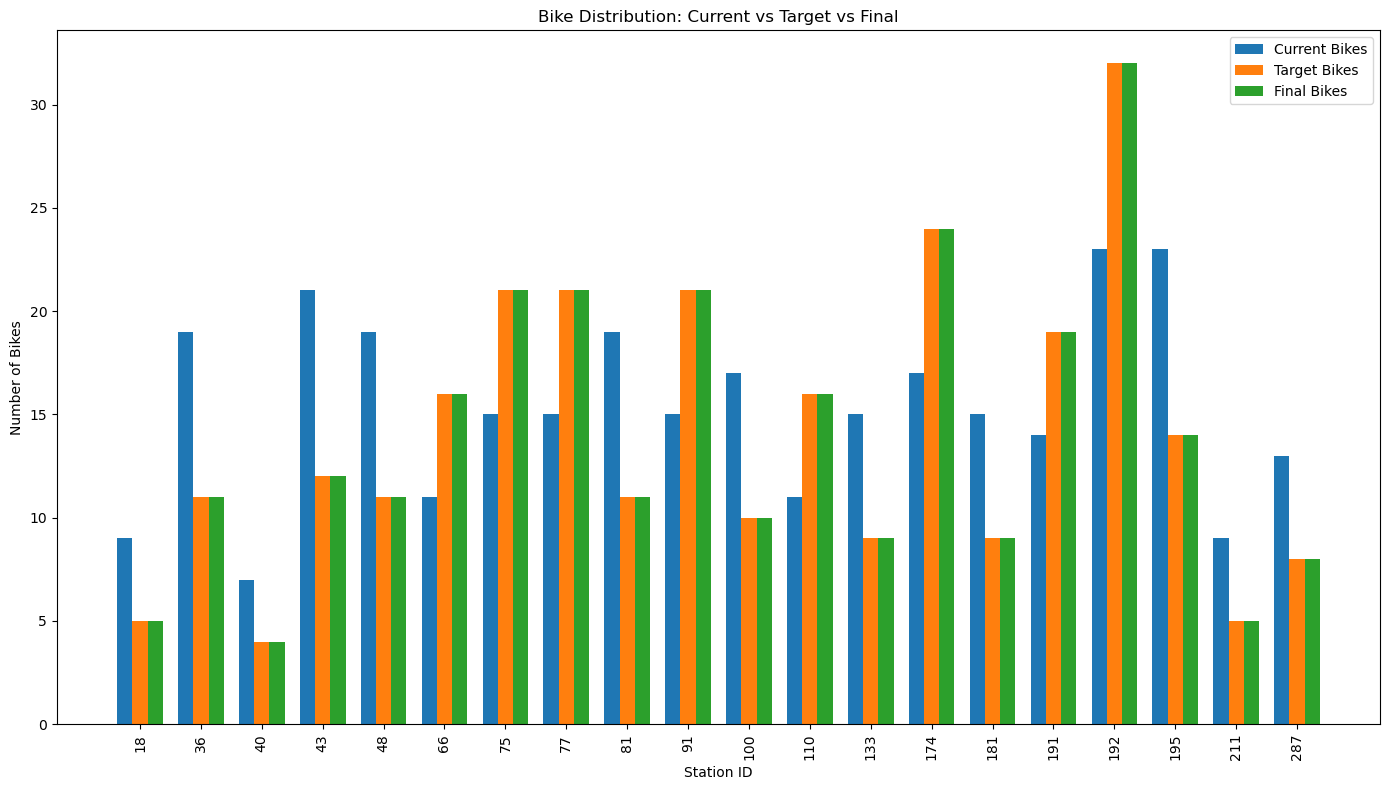

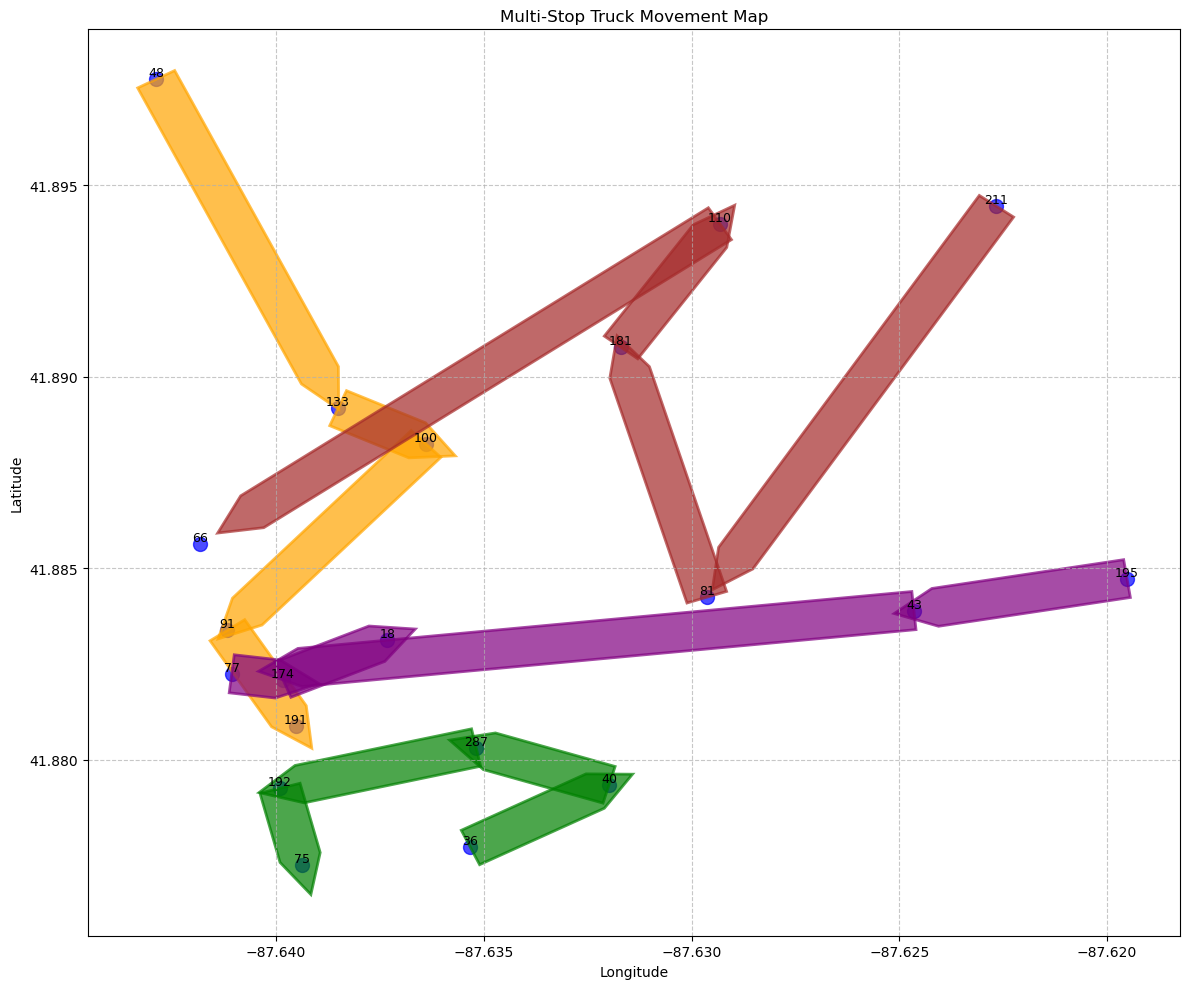

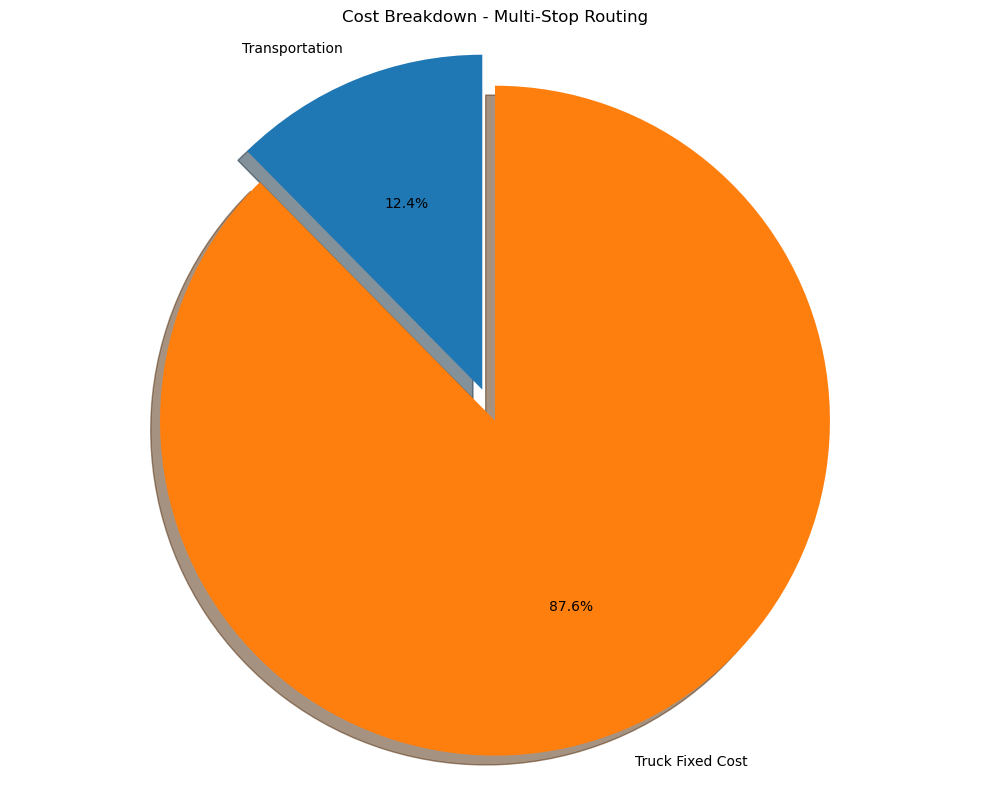

In [28]:
# --- Visualization Section ---

# 1. Bar Chart: Current vs Target vs Final Bikes
plt.figure(figsize=(14, 8))
sorted_states = states_df.sort_values('station_id')
stations_x = sorted_states['station_id'].astype(str)
width = 0.25
x = np.arange(len(stations_x))

plt.bar(x - width, sorted_states['current_bikes'], width, label='Current Bikes')
plt.bar(x, sorted_states['target_bikes'], width, label='Target Bikes')
plt.bar(x + width, sorted_states['final_bikes'], width, label='Final Bikes')

plt.xlabel('Station ID')
plt.ylabel('Number of Bikes')
plt.title('Bike Distribution: Current vs Target vs Final')
plt.xticks(x, stations_x, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('bike_distribution_comparison_multistop.png')
plt.show()

# 2. Truck Movement Map: Plot station locations and truck routes
plt.figure(figsize=(12, 10))
plt.scatter(stations_top20['longitude'], stations_top20['latitude'], s=100, c='blue', alpha=0.7, label='Stations')

# Add station ID labels
for idx, row in stations_top20.iterrows():
    plt.text(row['longitude'], row['latitude'], str(row['id']), fontsize=9, ha='center', va='bottom')

colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']
for route in routes:
    color = colors[route['sequential_truck_id'] % len(colors)]
    stops = route['stops']
    for s in range(len(stops)-1):
        from_station = stops[s]['station_id']
        to_station = stops[s+1]['station_id']
        from_lon = stations_top20[stations_top20['id'] == from_station]['longitude'].values[0]
        from_lat = stations_top20[stations_top20['id'] == from_station]['latitude'].values[0]
        to_lon = stations_top20[stations_top20['id'] == to_station]['longitude'].values[0]
        to_lat = stations_top20[stations_top20['id'] == to_station]['latitude'].values[0]
        plt.arrow(from_lon, from_lat, (to_lon - from_lon) * 0.9, (to_lat - from_lat) * 0.9,
                  head_width=0.001, head_length=0.001, fc=color, ec=color, linewidth=2, alpha=0.7)
plt.title('Multi-Stop Truck Movement Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('truck_movement_map_multistop.png')
plt.show()

# 3. Pie Chart: Cost Breakdown
plt.figure(figsize=(10, 8))
cost_items = {
    'Transportation': transport_cost_value,
    'Truck Fixed Cost': truck_cost_value,
    'Surplus Penalty': surplus_cost_value,
    'Deficit Penalty': deficit_cost_value
}
# Remove any items with zero value for clarity
cost_items = {k: v for k, v in cost_items.items() if v > 0}
labels = list(cost_items.keys())
values = list(cost_items.values())

plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True, explode=[0.05] * len(values))
plt.axis('equal')
plt.title('Cost Breakdown - Multi-Stop Routing')
plt.tight_layout()
plt.savefig('cost_breakdown_multistop.png')
plt.show()


#### c. Data Export (Excel)

In [30]:
# Export tables into excels 
import os
# Define the output directory.
output_dir = r"C:\Users\tipha\OneDrive\Bureau\Mcgill\U3\BUSINESS ANALYTICS\MGSC 404\Final Project BIXI\model output"

# Create the directory if it does not exist.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Export the data frames to CSV files.
states_df.to_csv(os.path.join(output_dir, f"states_df_{day}.csv"), index=False)

print("Data frames exported successfully!")


Data frames exported successfully!
